## ModelDB usecase: Logging and Querying Model Metadata
This example features:

* XGboost model development and cross-validation
* verta's Python client logging observations and artifacts during validation
* verta's Python client retrieving the loss/accuracy plot and the trained model from the validation process

Follow the steps in this [repo](https://github.com/VertaAI/modeldb) to setup the environment.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn import datasets
from sklearn import model_selection
import xgboost as xgb

import multiprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from verta import Client
client = Client("http://localhost:3000")

#### Start - Project, Experiment, Experiment Run

In [3]:
proj = client.set_project("Digit Classification")
expt = client.set_experiment("XGBoost Model")
#run = client.set_experiment_run("First Run")

set existing Project: Digit Classification from personal workspace
set existing Experiment: XGBoost Model


### Data Science Model Development
#### Import Data

In [2]:
data = datasets.load_digits()
X = data['data']
y = data['target']

dtrain = xgb.DMatrix(X, label=y)

In [3]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [5]:
df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))),
                  columns=["pixel_{}".format(i) for i in range(X.shape[-1])] + ['digit'])

df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,digit
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4.0


<Figure size 432x288 with 0 Axes>

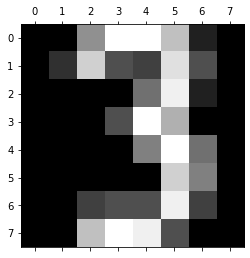

In [6]:
plt.gray()
plt.matshow(data.images[1300])
plt.show()

#### Hyperparameters Selection

In [7]:
grid = model_selection.ParameterGrid({
    'eta': [0.5, 0.7],
    'max_depth': [1, 2, 3],
    'num_class': [10],
})

#### Xgb and Cross Validation 
log the performance metric for hyperparameters

In [8]:
def run_experiment(hyperparams):
    # Separate run for every hyperparamers set
    run = client.set_experiment_run()
    
    # log training data
    run.log_dataset("train_data", df)
    
    # log hyperparameters
    run.log_hyperparameters(hyperparams)
    
    # run cross validation on hyperparameters
    cv_history = xgb.cv(hyperparams, dtrain,
                        nfold=5,
                        metrics=("merror", "mlogloss"))

    # log observations from each iteration
    for _, iteration in cv_history.iterrows():
        for obs, val in iteration.iteritems():
            run.log_observation(obs, val)
            
    # log error from final iteration
    final_val_error = iteration['test-merror-mean']
    run.log_metric("val_error", final_val_error)
    print("{} Mean error: {:.4f}".format(hyperparams, final_val_error))

with multiprocessing.Pool() as pool:
    pool.map(run_experiment, grid)

created new ExperimentRun: Run 137401585157465089399
created new ExperimentRun: Run 137421585157465359597
created new ExperimentRun: Run 137461585157465361975
created new ExperimentRun: Run 137431585157465360981
created new ExperimentRun: Run 137391585157465089089
created new ExperimentRun: Run 1374115851574650897229
upload complete (train_data.pkl)
upload complete (train_data.pkl)
upload complete (train_data.pkl)
upload complete (train_data.pkl)
upload complete (train_data.pkl)
upload complete (train_data.pkl)
{'eta': 0.7, 'max_depth': 1, 'num_class': 10} Mean error: 0.1252
{'eta': 0.7, 'max_depth': 2, 'num_class': 10} Mean error: 0.0584
{'eta': 0.5, 'max_depth': 1, 'num_class': 10} Mean error: 0.1352
{'eta': 0.5, 'max_depth': 2, 'num_class': 10} Mean error: 0.0751
{'eta': 0.5, 'max_depth': 3, 'num_class': 10} Mean error: 0.0545
{'eta': 0.7, 'max_depth': 3, 'num_class': 10} Mean error: 0.0473


#### Take best parameters and develope model

In [9]:
best_run = expt.expt_runs.sort("metrics.val_error", descending=False)[0]
print("Validation Error: {:.4f}".format(best_run.get_metric("val_error")))

best_hyperparams = best_run.get_hyperparameters()
print("Hyperparameters: {}".format(best_hyperparams))

Validation Error: 0.0473
Hyperparameters: {'eta': 0.7, 'max_depth': 3, 'num_class': 10}


In [10]:
# model development on full dataset
model = xgb.XGBClassifier(**best_hyperparams)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=10, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [13]:
# Log  model and Accuracy
best_run.log_model(model)
train_acc = model.score(X, y)
best_run.log_metric("train_acc", train_acc)
print("Training accuracy: {:.4f}".format(train_acc))

Training accuracy: 1.0000
